<img src="https://www.th-koeln.de/img/logo.svg" style="float:right;" width="200">

# 9th exercise: <font color="#C70039">Seasonal Autoregressive Integrated Moving Average model - SARIMA(p,d,q)(P,D,Q)_m: Passenger Forecast</font>
* Course: <a href="https://www.gernotheisenberg.de/time_series_forecasting.html">Time Series Forecasting (TSF)</a>
* Lecturer: <a href="https://www.gernotheisenberg.de/uebermich.html">Gernot Heisenberg</a>
* Date:   12.03.2025

<img src="./images/SARIMA.png" style="float: center;" width="450">

---------------------------------
**GENERAL NOTE 1**:
Please make sure you are reading the entire notebook, since it contains a lot of information on your tasks (e.g. regarding the set of certain paramaters or a specific computational trick), and the written mark downs as well as comments contain a lot of information on how things work together as a whole.

**GENERAL NOTE 2**:
* Please, when commenting source code, just use English language only.
* When describing an observation please use English language, too
* This applies to all exercises throughout this course.  

---------------------

### <font color="ce33ff">DESCRIPTION OF THE NOTEBOOK CONTENT</font>:
This notebook allows you for learning how to implement and apply another statistical model, an Seasonal Autoregressive Integrated Moving Average model of orders p, d and q SARIMA(p,d,q)(P,D,Q)_m.
We will directly compare the SARIMA to an ARIMA model and see which one performs better on the given seasonal data.

-------------------------------------------------------------------------------------------------------------

### <font color="FFC300">TASKS</font>:
The tasks that you need to work on within this notebook are always indicated below as bullet points.
If a task is more challenging and consists of several steps, this is indicated as well.
Make sure you have worked down the task list and commented your doings.
This should be done by using markdown.<br>
<font color=red>Make sure you don't forget to specify your name and your matriculation number in the notebook.</font>

**YOUR TASKS in this exercise are as follows**:
1. import the notebook to Google Colab or use your local machine.
2. make sure you specified you name and your matriculation number in the header below my name and date.
    * set the date too and remove mine.
3. read the entire notebook carefully
    * add comments whereever you feel it necessary for better understanding
    * run the notebook for the first time.
    * understand the output
4. Apply the SARIMA(p,d,q)(P,D,Q)m model on the Johnson & Johnson dataset
    * In the past notebooks, we applied an ARIMA(p,d,q) model to the Johnson & Johnson dataset to forecast the quarterly EPS over a year. 
    * Now use the SARIMA(p,d,q)(P,D,Q)m model on the same dataset and compare its performance to the ARIMA model.
    * Use time series decomposition to identify the presence of a periodic pattern.
    * Use the optimize_SARIMA function and select the model with the lowest AIC.
    * Perform residual analysis.
    * Forecast the EPS for the last year and measure the performance against the ARIMA model. 
    * Use the MAPE. Is it better?
-----------------------------------------------------------------------------------

## 9.0 Module import

In [19]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product
from typing import Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

## 9.1 Data Loading & Visualization

In [20]:
df = pd.read_csv('./data/air_passengers.csv')
df.head()

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


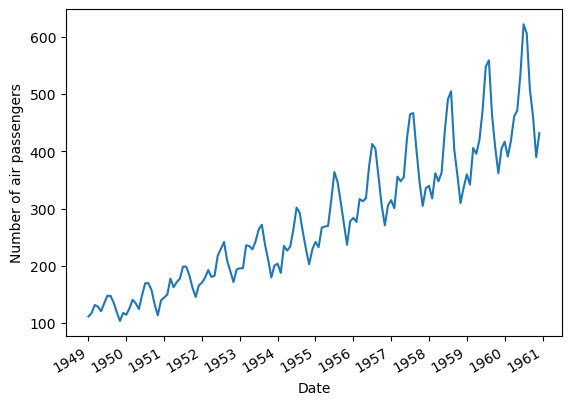

In [21]:
fig, ax = plt.subplots()

ax.plot(df['Month'], df['Passengers'])
ax.set_xlabel('Date')
ax.set_ylabel('Number of air passengers')

plt.xticks(np.arange(0, 145, 12), np.arange(1949, 1962, 1))

fig.autofmt_xdate()
plt.show()

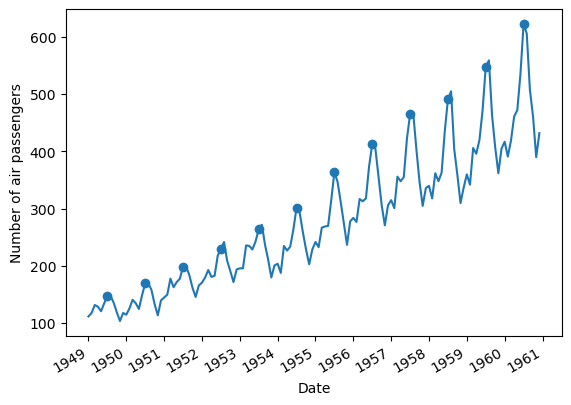

In [22]:
fig, ax = plt.subplots()

ax.plot(df['Month'], df['Passengers'], markevery=np.arange(6, 145, 12), marker='o')
ax.set_xlabel('Date')
ax.set_ylabel('Number of air passengers')

plt.xticks(np.arange(0, 145, 12), np.arange(1949, 1962, 1))

fig.autofmt_xdate()
plt.show()

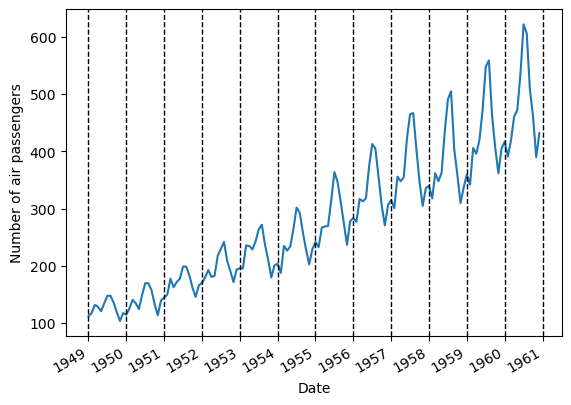

In [24]:
fig, ax = plt.subplots()

ax.plot(df['Month'], df['Passengers'])
for i in np.arange(0, 145, 12):
    ax.axvline(x=i, linestyle='--', color='black', linewidth=1)
ax.set_xlabel('Date')
ax.set_ylabel('Number of air passengers')

plt.xticks(np.arange(0, 145, 12), np.arange(1949, 1962, 1))

fig.autofmt_xdate()
plt.show()

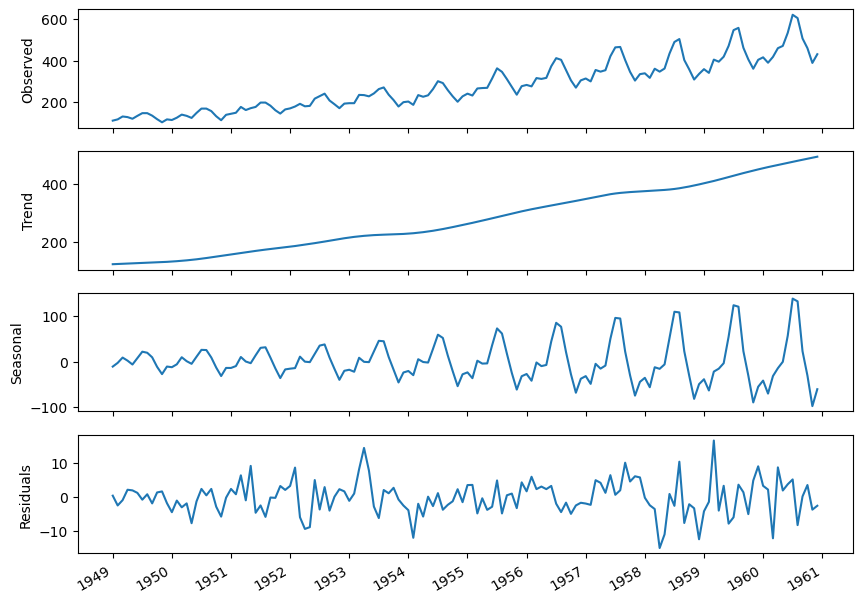

In [25]:
decomposition = STL(df['Passengers'], period=12).fit()

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(10,8))

ax1.plot(decomposition.observed)
ax1.set_ylabel('Observed')

ax2.plot(decomposition.trend)
ax2.set_ylabel('Trend')

ax3.plot(decomposition.seasonal)
ax3.set_ylabel('Seasonal')

ax4.plot(decomposition.resid)
ax4.set_ylabel('Residuals')

plt.xticks(np.arange(0, 145, 12), np.arange(1949, 1962, 1))

fig.autofmt_xdate()
plt.show()

#### Artificially created linear time series in order to illustrate and comprehend how the the decomposition works

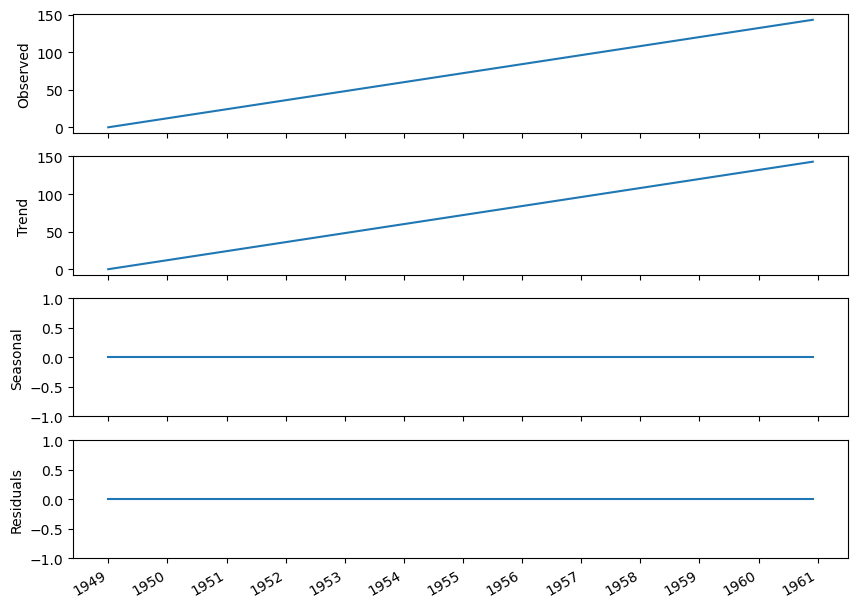

In [26]:
linear_ts = np.arange(0, 144, 1)

decomposition = STL(linear_ts, period=12).fit()

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(10,8))

ax1.plot(decomposition.observed)
ax1.set_ylabel('Observed')

ax2.plot(decomposition.trend)
ax2.set_ylabel('Trend')

ax3.plot(decomposition.seasonal)
ax3.set_ylabel('Seasonal')
ax3.set_ylim(-1, 1)

ax4.plot(decomposition.resid)
ax4.set_ylabel('Residuals')
ax4.set_ylim(-1, 1)

plt.xticks(np.arange(0, 145, 12), np.arange(1949, 1962, 1))

fig.autofmt_xdate()
plt.show()

## 9.2 Augmented Dickey-Fuller test

In [27]:
ad_fuller_result = adfuller(df['Passengers'])

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: 0.8153688792060597
p-value: 0.9918802434376411


#### 1st order differencing and ADF test

In [28]:
df_diff = np.diff(df['Passengers'], n=1)

ad_fuller_result = adfuller(df_diff)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -2.829266824169992
p-value: 0.0542132902838265


#### 2nd order differencing and ADF test

In [29]:
df_diff2 = np.diff(df_diff, n=1)

ad_fuller_result = adfuller(df_diff2)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -16.384231542468527
p-value: 2.732891850014085e-29


#### RESULT for d
now the time series is stationary -> d=2

#### Seasonal differencing and ADF test
Since we have monthly data, m = 12, so the seasonal difference is the difference between two values that are 12 timesteps apart (see below).
NOTE, that we apply the seasonal differencing on the 1st order differenced data, even though the ADF test revealed that this one was not stationary yet.

In [30]:
df_diff_seasonal_diff = np.diff(df_diff, n=12) # Note, that n=12

ad_fuller_result = adfuller(df_diff_seasonal_diff)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -17.624862360181496
p-value: 3.823046855924265e-30


With a large and negative ADF statistic and a p-value smaller than 0.05, we can reject the null hypothesis and consider the transformed series as stationary. 
Therefore, we performed one round of differencing, meaning that d = 1 and one round of seasonal differencing, meaning that D = 1.

REMEMBER that for the ARIMA model d=2, since we needed a 2nd order differencing round here.

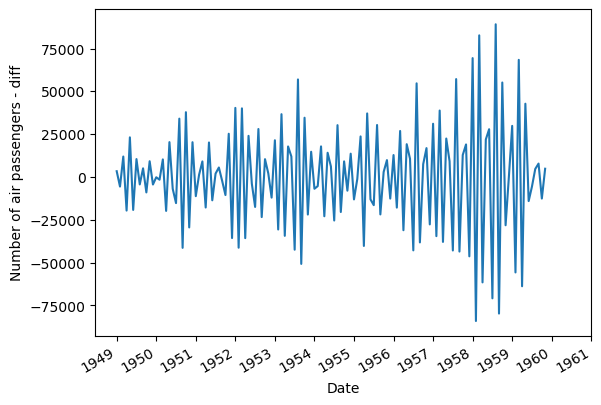

In [12]:
fig, ax = plt.subplots()

ax.plot(df['Month'][13:], df_diff_seasonal_diff)
ax.set_xlabel('Date')
ax.set_ylabel('Number of air passengers - diff')

plt.xticks(np.arange(0, 145, 12), np.arange(1949, 1962, 1))

fig.autofmt_xdate()
plt.show()

#### Visualize the original time series (forcasting year highlighted in gray) 

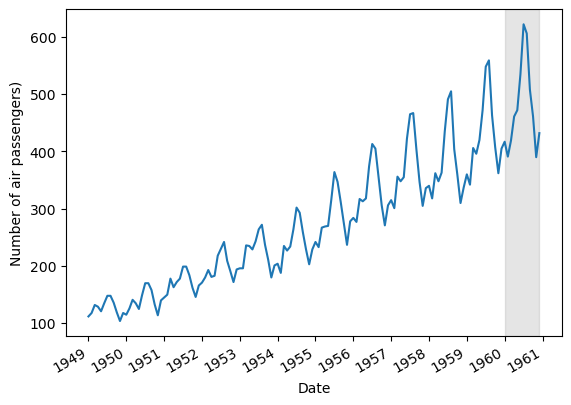

In [13]:
fig, ax = plt.subplots()

ax.plot(df['Month'], df['Passengers'])
ax.set_xlabel('Date')
ax.set_ylabel('Number of air passengers)')
ax.axvspan(132, 143, color='#808080', alpha=0.2)

plt.xticks(np.arange(0, 145, 12), np.arange(1949, 1962, 1))

fig.autofmt_xdate()
plt.show()

## 9.3 Optimizing the ARIMA and SARIMA model, respectively

Implement ARIMA and SARIMA since we are benchmarking them against each other. 
Also, this is a nice way to compare and see the slight differences between both implementations.

In [12]:
def optimize_ARIMA(endog: Union[pd.Series, list], order_list: list, d: int) -> pd.DataFrame:

    results = []

    for order in tqdm_notebook(order_list):
        try:
            model = SARIMAX(endog, order=(order[0], d, order[1]), simple_differencing=False).fit(disp=False)
        except:
            continue

        aic = model.aic
        results.append([order, aic])

    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'AIC']

    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)

    return result_df

In [13]:
''' NOTE: s in the code = m in the slides by convention of the SARIMAX function'''
def optimize_SARIMA(endog: Union[pd.Series, list], order_list: list, d: int, D: int, s: int) -> pd.DataFrame:

    results = []

    for order in tqdm_notebook(order_list):
        try:
            # in comparison to the ARIMA model you just have to add the specification of the seasonal order
            # all the rest remains the same
            model = SARIMAX(endog, order=(order[0], d, order[1]), seasonal_order=(order[2], D, order[3], s), simple_differencing=False).fit(disp=False)
        except:
            continue

        aic = model.aic
        results.append([order, aic])

    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q,P,Q)', 'AIC']

    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)

    return result_df

## 9.4 Model building and training

### ARIMA model setup
We will specifically choose a range from 0 to 12 to allow the ARIMA model to go back 12 timesteps in time. 
Since the data is sampled monthly and we already know that it is seasonal, we can hypothesize that the number of air passengers in January of a given year is likely predictive of the number of air passengers in January of the following year. Since these two points are 12 timesteps apart, we’ll allow the values of p and q to vary from 0 to 12 in order to potentially capture this seasonal information
in the ARIMA(p,d,q) model.

Since we want to first set up an ARIMA model, we set P and Q to zero.

In [31]:
ps = range(0, 13, 1)
qs = range(0, 13, 1)
Ps = [0]
Qs = [0]

d = 2
D = 0
s = 12

ARIMA_order_list = list(product(ps, qs, Ps, Qs))
#DEBUG
ARIMA_order_list

[(0, 0, 0, 0),
 (0, 1, 0, 0),
 (0, 2, 0, 0),
 (0, 3, 0, 0),
 (0, 4, 0, 0),
 (0, 5, 0, 0),
 (0, 6, 0, 0),
 (0, 7, 0, 0),
 (0, 8, 0, 0),
 (0, 9, 0, 0),
 (0, 10, 0, 0),
 (0, 11, 0, 0),
 (0, 12, 0, 0),
 (1, 0, 0, 0),
 (1, 1, 0, 0),
 (1, 2, 0, 0),
 (1, 3, 0, 0),
 (1, 4, 0, 0),
 (1, 5, 0, 0),
 (1, 6, 0, 0),
 (1, 7, 0, 0),
 (1, 8, 0, 0),
 (1, 9, 0, 0),
 (1, 10, 0, 0),
 (1, 11, 0, 0),
 (1, 12, 0, 0),
 (2, 0, 0, 0),
 (2, 1, 0, 0),
 (2, 2, 0, 0),
 (2, 3, 0, 0),
 (2, 4, 0, 0),
 (2, 5, 0, 0),
 (2, 6, 0, 0),
 (2, 7, 0, 0),
 (2, 8, 0, 0),
 (2, 9, 0, 0),
 (2, 10, 0, 0),
 (2, 11, 0, 0),
 (2, 12, 0, 0),
 (3, 0, 0, 0),
 (3, 1, 0, 0),
 (3, 2, 0, 0),
 (3, 3, 0, 0),
 (3, 4, 0, 0),
 (3, 5, 0, 0),
 (3, 6, 0, 0),
 (3, 7, 0, 0),
 (3, 8, 0, 0),
 (3, 9, 0, 0),
 (3, 10, 0, 0),
 (3, 11, 0, 0),
 (3, 12, 0, 0),
 (4, 0, 0, 0),
 (4, 1, 0, 0),
 (4, 2, 0, 0),
 (4, 3, 0, 0),
 (4, 4, 0, 0),
 (4, 5, 0, 0),
 (4, 6, 0, 0),
 (4, 7, 0, 0),
 (4, 8, 0, 0),
 (4, 9, 0, 0),
 (4, 10, 0, 0),
 (4, 11, 0, 0),
 (4, 12, 0, 0),
 (5, 0, 0,

In [15]:
train = df['Passengers'][:-12]

ARIMA_result_df = optimize_SARIMA(train, ARIMA_order_list, d, D, s)
ARIMA_result_df

  0%|          | 0/169 [00:00<?, ?it/s]

,"(p,q,P,Q)",AIC
0,"(11, 3, 0, 0)",1016.860517
1,"(11, 4, 0, 0)",1019.012587
2,"(12, 0, 0, 0)",1020.386447
3,"(11, 5, 0, 0)",1020.412171
4,"(11, 1, 0, 0)",1021.016159
...,...,...
164,"(5, 0, 0, 0)",1281.732157
165,"(3, 0, 0, 0)",1300.282335
166,"(2, 0, 0, 0)",1302.913196
167,"(1, 0, 0, 0)",1308.152194


#### INTERMEDIATE RESULT
This returns a DataFrame where the model with the lowest AIC is a SARIMA(11,2,3)(0,0,0)_12 model, which is equivalent to an ARIMA(11,2,3) model. 
As you can see, allowing the order p to vary from 0 to 12 was beneficial for the model, as the model with the lowest AIC takes into account the past 11 values of the series, since
p = 11. 
We will see if this is enough to capture seasonal information from the series and we will compare the performance of the ARIMA model to the SARIMA model in the next section.

However, let's perform the residual analysis first before we proceed.

In [16]:
# investigate the SARIMAX results
ARIMA_model = SARIMAX(train, order=(11,2,3), simple_differencing=False)
ARIMA_model_fit = ARIMA_model.fit(disp=False)

print(ARIMA_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:             Passengers   No. Observations:                  132
Model:              SARIMAX(11, 2, 3)   Log Likelihood                -493.430
Date:                Wed, 30 Apr 2025   AIC                           1016.861
Time:                        16:20:52   BIC                           1059.874
Sample:                             0   HQIC                          1034.338
                                - 132                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8244      0.101     -8.197      0.000      -1.022      -0.627
ar.L2         -0.9615      0.049    -19.621      0.000      -1.058      -0.865
ar.L3         -0.8508      0.088     -9.714      0.0

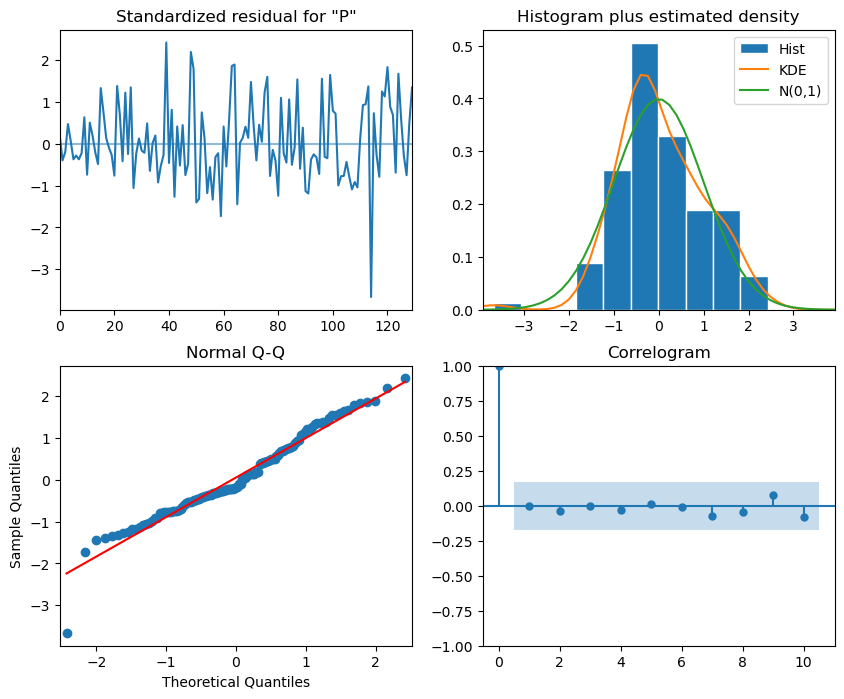

In [17]:
ARIMA_model_fit.plot_diagnostics(figsize=(10,8))
plt.show()

In [18]:
residuals = ARIMA_model_fit.resid

lb_value = acorr_ljungbox(residuals, np.arange(1, 11, 1))

print(lb_value)

      lb_stat  lb_pvalue
1    6.440891   0.011152
2    6.551069   0.037797
3    6.818110   0.077927
4    7.623069   0.106403
5    8.261752   0.142388
6    8.562565   0.199714
7    9.407657   0.224697
8    9.640050   0.291204
9    9.648769   0.379660
10  11.411524   0.326368


#### INTERMEDIATE RESULT - Residuals’ diagnostics of the ARIMA(11,2,3) model. 
In the top-left plot, the residuals have no trend with a variance that seems fairly constant over time, which resembles the behavior of white noise. 
The top-right plot shows the distribution of the residuals, which approaches a normal distribution, despite the unusual peak. 
This is further confirmed by the Q-Q plot at the bottom left, which displays a fairly straight line that lies on y = x. Finally, the correlogram in the bottom-right plot shows no significant
autocorrelation coefficients after lag 0, which is exactly like white noise. From this analysis, the residuals resemble white noise.

Also the Ljung-Box-test reveals that the residuals resemble white noise since all returned p-values are all greater than 0.05 except for the first two values. This means that, according to the Ljung-Box test, we reject the null hypothesis with a 5% chance of being wrong, since we set our significance boundary to 0.05. However, the third value and onwards are all greater than 0.05, so we reject the null hypothesis, concluding that the residuals are uncorrelated starting at lag 3.

<font color=red>NOTE:</font> This is an interesting situation to dissect, because the graphical analysis of the residuals leads us to conclude that they resemble white noise, but the Ljung-Box test, however, points to some correlation at lags 1 and 2. This means that our ARIMA model is not capturing all the information from the data as to be expected, since we are modeling seasonal data with a non-seasonal model.

So, let's proceed and setup the SARIMA mode finally.

### SARIMA model setup

In [24]:
ps = range(0, 4, 1)
qs = range(0, 4, 1)
Ps = range(0, 4, 1)
Qs = range(0, 4, 1)

SARIMA_order_list = list(product(ps, qs, Ps, Qs))

train = df['Passengers'][:-12]

d = 1
D = 1
s = 12

SARIMA_result_df = optimize_SARIMA(train, SARIMA_order_list, d, D, s)
SARIMA_result_df

  0%|          | 0/256 [00:00<?, ?it/s]

,"(p,q,P,Q)",AIC
0,"(2, 1, 1, 2)",892.241198
1,"(2, 1, 2, 1)",894.040682
2,"(2, 1, 1, 3)",894.094972
3,"(1, 0, 1, 2)",894.290953
4,"(0, 1, 1, 2)",894.995190
...,...,...
248,"(0, 0, 2, 0)",906.940147
249,"(3, 2, 0, 3)",907.181875
250,"(0, 0, 3, 2)",907.476796
251,"(0, 0, 3, 0)",908.742583


#### INTERMEDIATE RESULT
We find that the SARIMA(2,1,1)(1,1,2)_12 model has got the lowest AIC. We can fit this model again on the training set to perform a residual analysis qualitatively and quantitatively.

In [25]:
# investigate the SARIMAX results
SARIMA_model = SARIMAX(train, order=(2,1,1), seasonal_order=(1,1,2,12), simple_differencing=False)
SARIMA_model_fit = SARIMA_model.fit(disp=False)

print(SARIMA_model_fit.summary())

                                        SARIMAX Results                                        
Dep. Variable:                              Passengers   No. Observations:                  132
Model:             SARIMAX(2, 1, 1)x(1, 1, [1, 2], 12)   Log Likelihood                -439.121
Date:                                 Wed, 12 Mar 2025   AIC                            892.241
Time:                                         16:55:29   BIC                            911.695
Sample:                                              0   HQIC                           900.141
                                                 - 132                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.2666      0.084    -15.000      0.000      -1.432      -1

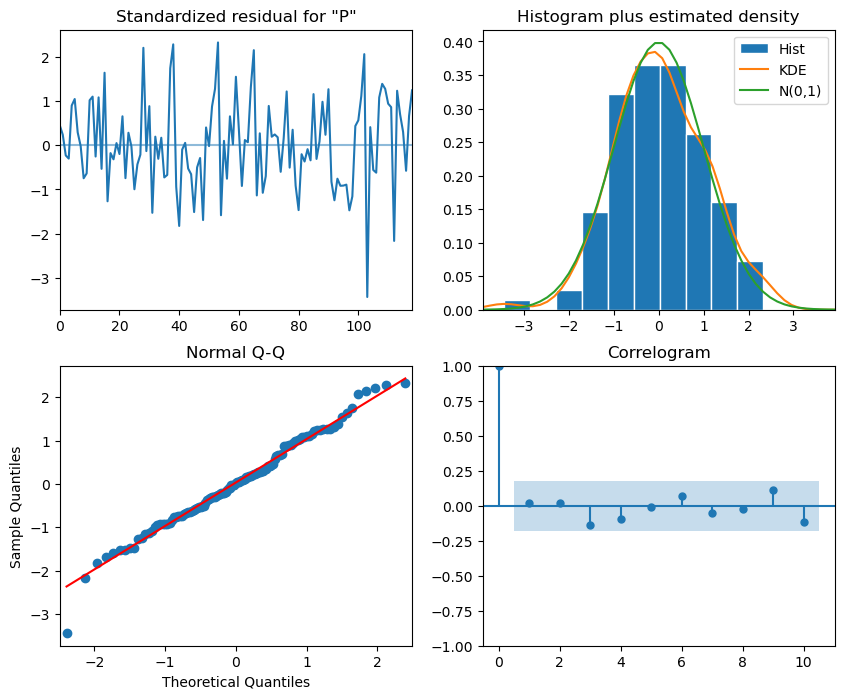

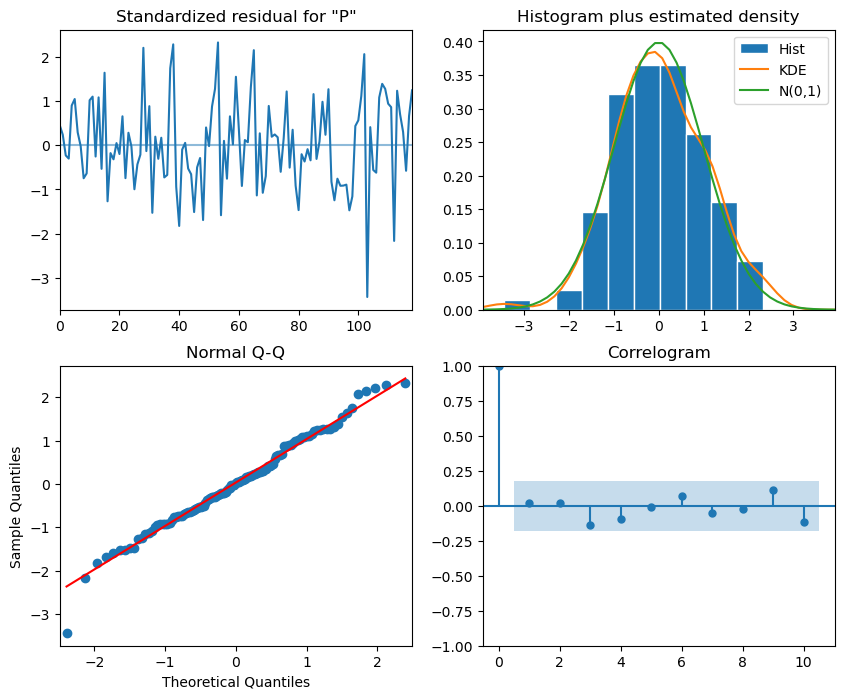

In [26]:
SARIMA_model_fit.plot_diagnostics(figsize=(10,8))
plt.show()

In [27]:
residuals = SARIMA_model_fit.resid

lb_value = acorr_ljungbox(residuals, np.arange(1, 11, 1))

print(lb_value)

     lb_stat  lb_pvalue
1   0.004885   0.944278
2   0.745316   0.688901
3   1.021387   0.796077
4   1.225958   0.873807
5   1.436377   0.920293
6   1.711207   0.944253
7   2.306972   0.940918
8   2.716688   0.950860
9   2.732864   0.973952
10  4.966736   0.893389


## 9.5 Forecasting passengers with both ARIMA & SARIMA models as well as a baseline model

In [ ]:
test = df.iloc[-12:]

# baseline model
test['naive_seasonal'] = df['Passengers'].iloc[120:132].values
test

In [ ]:
ARIMA_pred = ARIMA_model_fit.get_prediction(132, 143).predicted_mean

test['ARIMA_pred'] = ARIMA_pred
test

In [ ]:
SARIMA_pred = SARIMA_model_fit.get_prediction(132, 143).predicted_mean

test['SARIMA_pred'] = SARIMA_pred
test

In [ ]:
# visualize data and preditions for better comparability
fig, ax = plt.subplots()

ax.plot(df['Month'], df['Passengers'])
ax.plot(test['Passengers'], 'b-', label='actual')
ax.plot(test['naive_seasonal'], 'r:', label='naive seasonal')
ax.plot(test['ARIMA_pred'], 'k--', label='ARIMA(11,2,3)')
ax.plot(test['SARIMA_pred'], 'g-.', label='SARIMA(2,1,1)(1,1,2,12)')

ax.set_xlabel('Date')
ax.set_ylabel('Number of air passengers')
ax.axvspan(132, 143, color='#808080', alpha=0.2)

ax.legend(loc=2)

plt.xticks(np.arange(0, 145, 12), np.arange(1949, 1962, 1))
ax.set_xlim(120, 143)

fig.autofmt_xdate()
plt.show()

In [ ]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
mape_naive_seasonal = mape(test['Passengers'], test['naive_seasonal'])
mape_ARIMA = mape(test['Passengers'], test['ARIMA_pred'])
mape_SARIMA = mape(test['Passengers'], test['SARIMA_pred'])

print(mape_naive_seasonal, mape_ARIMA, mape_SARIMA)

In [ ]:
# compare the naive seasonal and ARIMA scenarios in a bar plot
fig, ax = plt.subplots()

x = ['naive seasonal', 'ARIMA(11,2,3)', 'SARIMA(2,1,1)(1,1,2,12)']
y = [mape_naive_seasonal, mape_ARIMA, mape_SARIMA]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Models')
ax.set_ylabel('MAPE (%)')
ax.set_ylim(0, 15)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 1, s=str(round(value,2)), ha='center')
plt.show()